In [1]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
import subprocess

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import csv

# Define the directory containing the sound files
directory = "./NorthernBobwhiteCNN"

# Create an empty list to hold the data
data = []

# Loop over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        # Extract the sound type from the filename
        if "Absence" in filename:
            bird = "absent"
            sound_type = "na"
        else:
            bird = "present"
            sound_type = "song"

        # Create a dictionary for the sound file
        sound = {"filename": os.path.join(directory, filename), "NorthernBobwhite": bird, "sound_type": sound_type}

        # Append the sound dictionary to the data list
        data.append(sound)

# Define the fieldnames for the CSV file
fieldnames = ["filename", "NorthernBobwhite", "sound_type"]

# Open a new CSV file in write mode
with open("bobwhite_data.csv", mode="w", newline='') as file:

    # Create a CSV writer object
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header row to the CSV file
    writer.writeheader()

    # Write each dictionary to a row in the CSV file
    for row in data:
        writer.writerow(row)


In [3]:
import pandas as pd

bobwhite_data = pd.read_csv('bobwhite_data.csv')

# create a new dataframe with the filenames from the previous table as the index
labels = pd.DataFrame(index=bobwhite_data['filename'])

#convert 'present' to 1 and 'absent' to 0
labels['NorthernBobwhite']=[1 if l=='present' else 0 for l in bobwhite_data['NorthernBobwhite']]

#look at the first rows
labels.head(3)

,NorthernBobwhite
filename,
./NorthernBobwhiteCNN/WLFW_GA_TrainingClip_Presence (12).wav,1
./NorthernBobwhiteCNN/WLFW_GA_TrainingClip_Presence (13).wav,1
./NorthernBobwhiteCNN/WLFW_AL_TrainingClip_Absence (42).wav,0


In [4]:
from sklearn.model_selection import train_test_split
train_df,validation_df = train_test_split(labels,test_size=0.2,random_state=1)

In [5]:
from opensoundscape.torch.models.cnn import load_model
import os

# Define constants
SAMPLE_DURATION = 4.0
NUM_EPOCHS = 15
BATCH_SIZE = 10
SAVE_INTERVAL = 150

# Specify paths
model_path = './bird_training/bobwhite/best.model'
save_path = './bird_training/bobwhite'

# Create model object
classes = train_df.columns #in this case, there's just one class: ["woodcock"]

if os.path.exists(model_path):
    model = load_model(model_path)
else:
    model = CNN('resnet18', classes=classes, sample_duration=SAMPLE_DURATION)

model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path=save_path,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    save_interval=SAVE_INTERVAL,
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
)

model.save(model_path)
model = load_model(model_path)


Training Epoch 45
Epoch: 45 [batch 0/15 (0.00%)] 
	DistLoss: 0.081
Metrics:
Epoch: 45 [batch 10/15 (66.67%)] 
	DistLoss: 0.110
Metrics:
Metrics:
	MAP: 0.989

Validation.
[]
Metrics:
	MAP: 0.974

Training Epoch 46
Epoch: 46 [batch 0/15 (0.00%)] 
	DistLoss: 0.098
Metrics:
Epoch: 46 [batch 10/15 (66.67%)] 
	DistLoss: 0.087
Metrics:
Metrics:
	MAP: 0.995

Validation.
[]
Metrics:
	MAP: 0.981

Training Epoch 47
Epoch: 47 [batch 0/15 (0.00%)] 
	DistLoss: 0.103
Metrics:
Epoch: 47 [batch 10/15 (66.67%)] 
	DistLoss: 0.107
Metrics:
Metrics:
	MAP: 0.994

Validation.
[]
Metrics:
	MAP: 0.983

Training Epoch 48
Epoch: 48 [batch 0/15 (0.00%)] 
	DistLoss: 0.088
Metrics:
Epoch: 48 [batch 10/15 (66.67%)] 
	DistLoss: 0.199
Metrics:
Metrics:
	MAP: 0.985

Validation.
[]
Metrics:
	MAP: 0.978

Training Epoch 49
Epoch: 49 [batch 0/15 (0.00%)] 
	DistLoss: 0.071
Metrics:
Epoch: 49 [batch 10/15 (66.67%)] 
	DistLoss: 0.153
Metrics:
Metrics:
	MAP: 0.992

Validation.
[]
Metrics:
	MAP: 0.977

Training Epoch 50
Epoch:

/root/bird/kitzes/lib/python3.8/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


Text(0, 0.5, 'loss')

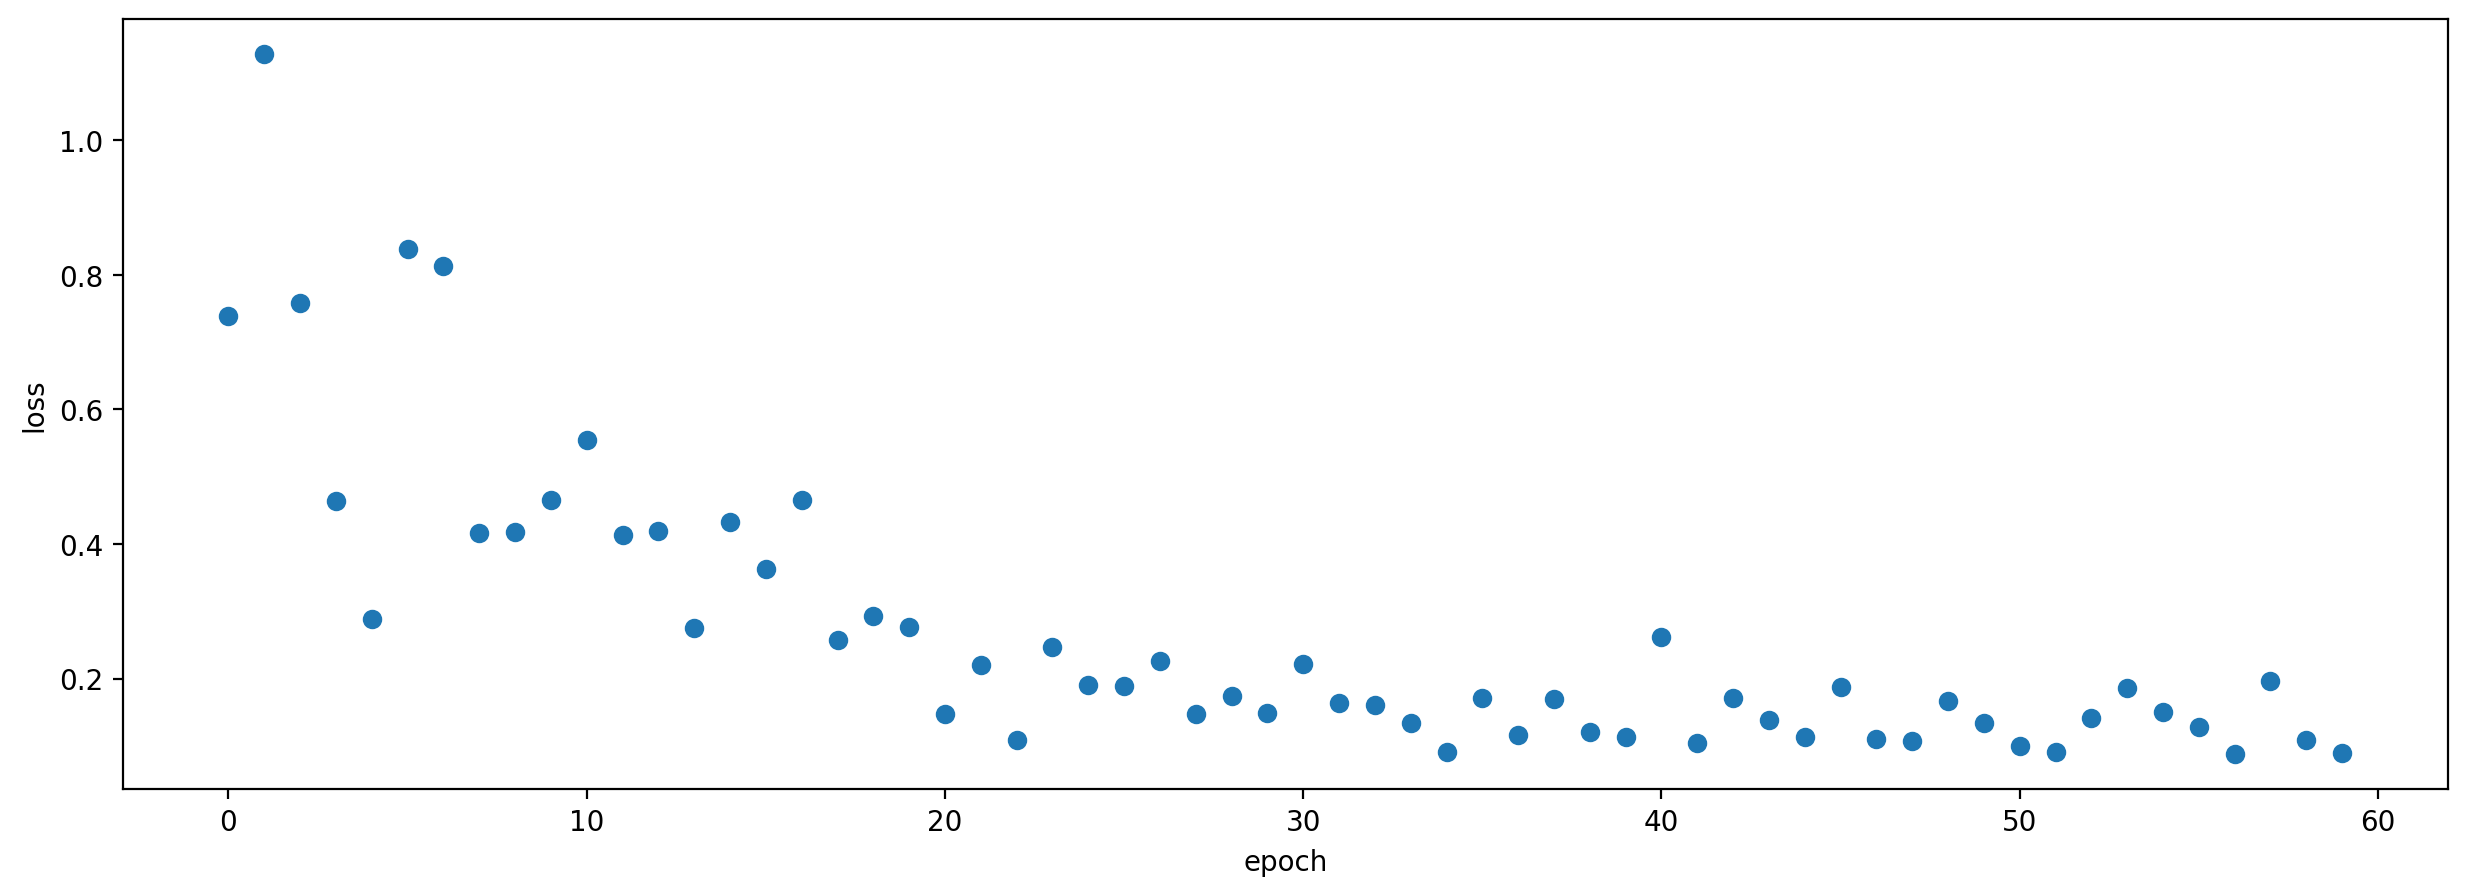

In [6]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [7]:
from glob import glob
field_recordings = glob('./NorthernBobwhite_Recording/*.WAV')

field_recordings

['./NorthernBobwhite_Recording/20221022_060000.WAV']

In [8]:
#all with overlap
import os
import pandas as pd
# import Audio and Spectrogram classes from OpenSoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram



#predict method returns a LIST of dataframes, so in this case, prediction_scores_df is list of one dataframe
prediction_scores_df = model.predict(field_recordings, activation_layer='sigmoid', overlap_fraction = .5)



# Add a new column 'Presence' based on the value of 'woodcock' column
prediction_scores_df[0]['Presence'] = ['Present' if float(score) > 0.9 else '' for score in prediction_scores_df[0]['NorthernBobwhite']]


      
prediction_scores_df[0].to_csv("bobwhite.csv")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('bobwhite.csv')

# Convert the seconds column to a "minute:second" format
df['start_time'] = pd.to_datetime(df['start_time'], unit='s').apply(lambda x: x.strftime('%H:%M:%S'))
df['end_time'] = pd.to_datetime(df['end_time'], unit='s').apply(lambda x: x.strftime('%H:%M:%S'))

# Save the updated DataFrame to the same CSV file
df.to_csv('bobwhite.csv', index=False)

[]
